In [1]:
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt
import csv
from PIL import Image
import pytesseract


In [2]:
import os 
os.getcwd()
os.chdir('c:\\Users\\Admin\\Desktop\\ComputerVision\\OCR\\Other\\data2')


In [3]:
def preproces_extract_img_1(img_path:str,custom_config='-l fra --psm 6 '):
    filename = os.path.splitext(os.path.basename(img_path))[0]
    img=cv.imread(img_path)
    # img=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.figure(figsize=(16,16))
    plotting = plt.imshow(img,cmap='gray')
    plt.show()
    #preprocess
    img_resized= cv.resize(img, None, fx=2, fy=2, interpolation=cv.INTER_CUBIC) #resolution x 2
    text=pytesseract.image_to_string(img_resized,config=custom_config)

    
    with open(f"Resultat/Ocr_Txt/{filename}_OCR.txt", "w",encoding='UTF-16 LE') as f:
        f.write(text)

    return text



In [4]:
def preproces_extract_img_2(img_path:str,custom_config='-l fra --psm 6 '):
    filename = os.path.splitext(os.path.basename(img_path))[0]
    img=cv.imread(img_path)
    # img=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.figure(figsize=(16,16))
    plotting = plt.imshow(img,cmap='gray')
    plt.show()

    text=pytesseract.image_to_string(img,config=custom_config)

    
    with open(f"Resultat/Test_Txt/{filename}_OCR_SansRES.txt", "w",encoding='UTF-16 LE') as f:
        f.write(text)

    return text

In [5]:
def preproces_extract_img_3(img_path:str,custom_config='-l fra --psm 6'):
    filename = os.path.splitext(os.path.basename(img_path))[0]
    img=cv.imread(img_path)
    plt.figure(figsize=(16,16))
    plotting = plt.imshow(img,cmap='gray')
    plt.show()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    (thresh, img_bin) = cv.threshold(img_gray, 180, 255, cv.THRESH_BINARY)
    img_bin = cv.bitwise_not(img_bin)

    kernel_length_v = (np.array(img_gray).shape[1])//200
    vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, kernel_length_v)) 
    im_temp1 = cv.erode(img_bin, vertical_kernel, iterations=5)
    vertical_lines_img = cv.dilate(im_temp1, vertical_kernel, iterations=5)

    kernel_length_h = (np.array(img_gray).shape[1])//100
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (kernel_length_h, 1))
    im_temp2 = cv.erode(img_bin, horizontal_kernel, iterations=5)
    horizontal_lines_img = cv.dilate(im_temp2, horizontal_kernel, iterations=5)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    table_segment = cv.addWeighted(vertical_lines_img, 0.5, horizontal_lines_img, 0.5, 0.0)
    table_segment = cv.erode(cv.bitwise_not(table_segment), kernel, iterations=2)
    thresh, table_segment = cv.threshold(table_segment, 0, 255, cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(table_segment, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    l1=[]
    for i,c in enumerate(contours):
        x, y, w, h = cv.boundingRect(c)
        if (w > 0 and h > 0) :
            cropped = img[y-3:y + h, x-3:x + w]
            if cropped.shape[0]<= img.shape[0]/1: 
                kernel = cv.getStructuringElement(cv.MORPH_RECT, (2, 1))
                resizing = cv.resize(cropped, None, fx=2, fy=2, interpolation=cv.INTER_CUBIC)
                txt_1=pytesseract.image_to_string(resizing,config=custom_config).strip()
                l1.append(txt_1)

    with open(f"Resultat/Test_Txt/{filename}_OCR.txt", "w",encoding='UTF-16 LE') as f:
        for item in l1:
            f.write("%s\n" % item)

              
    

In [13]:
def preproces_extract_img_4(img_path:str,custom_config='-l fra --psm 6 '):
    filename = os.path.splitext(os.path.basename(img_path))[0]
    img=cv.imread(img_path)
    img_rotated = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
    # img=cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    plt.figure(figsize=(16,16))
    plotting = plt.imshow(img_rotated,cmap='gray')
    plt.show()
    #preprocess
    img_resized= cv.resize(img_rotated, None, fx=2, fy=2, interpolation=cv.INTER_CUBIC) #resolution x 2
    text=pytesseract.image_to_string(img_resized,config=custom_config)

    
    with open(f"Resultat/Test_Txt/{filename}_OCR.txt", "w",encoding='UTF-16 LE') as f:
        f.write(text)

    return text

In [6]:
#calcul metrique 
import difflib
import Levenshtein
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics import spearman_correlation, ranks_from_sequence
from nltk.util import ngrams
from scipy.stats import rankdata, spearmanr


def calcul_metric(path_text1 , path_text2):
    with open(path_text1, 'r',encoding='UTF-16 LE') as file1:
        text1 = file1.read()
    with open(path_text2, 'r',encoding='UTF-16 LE') as file2:
        text2 = file2.read()

    #Levenshtein
    distance_lev = Levenshtein.distance(text1, text2)
    print("Distance de Levenshtein :", distance_lev)

    #coefficient jaccard 
    tokens1 = set(nltk.word_tokenize(text1.lower()))
    tokens2 = set(nltk.word_tokenize(text2.lower()))
    jaccard_coeff = len(tokens1.intersection(tokens2)) / len(tokens1.union(tokens2))
    print("Coefficient de Jaccard :", jaccard_coeff)

    #similarity_Dice 
    def dice_similarity(s1, s2, n=2):
        s1_ngrams = set(ngrams(s1, n))
        s2_ngrams = set(ngrams(s2, n))
        overlap = len(s1_ngrams & s2_ngrams)
        return 2 * overlap / (len(s1_ngrams) + len(s2_ngrams))

    similarity_dice = dice_similarity(tokens1, tokens2)
    print(f"Similarité de Dice : {similarity_dice:.2f}")


    #cosine similarity 
    textes = [text1, text2]
    vectorizer = CountVectorizer().fit_transform(textes)
    vectors = vectorizer.toarray()
    similarity_cosine = cosine_similarity(vectors)
    print( "cosine similarity : ",similarity_cosine[0][1]) 

    return distance_lev ,jaccard_coeff , similarity_dice , similarity_cosine



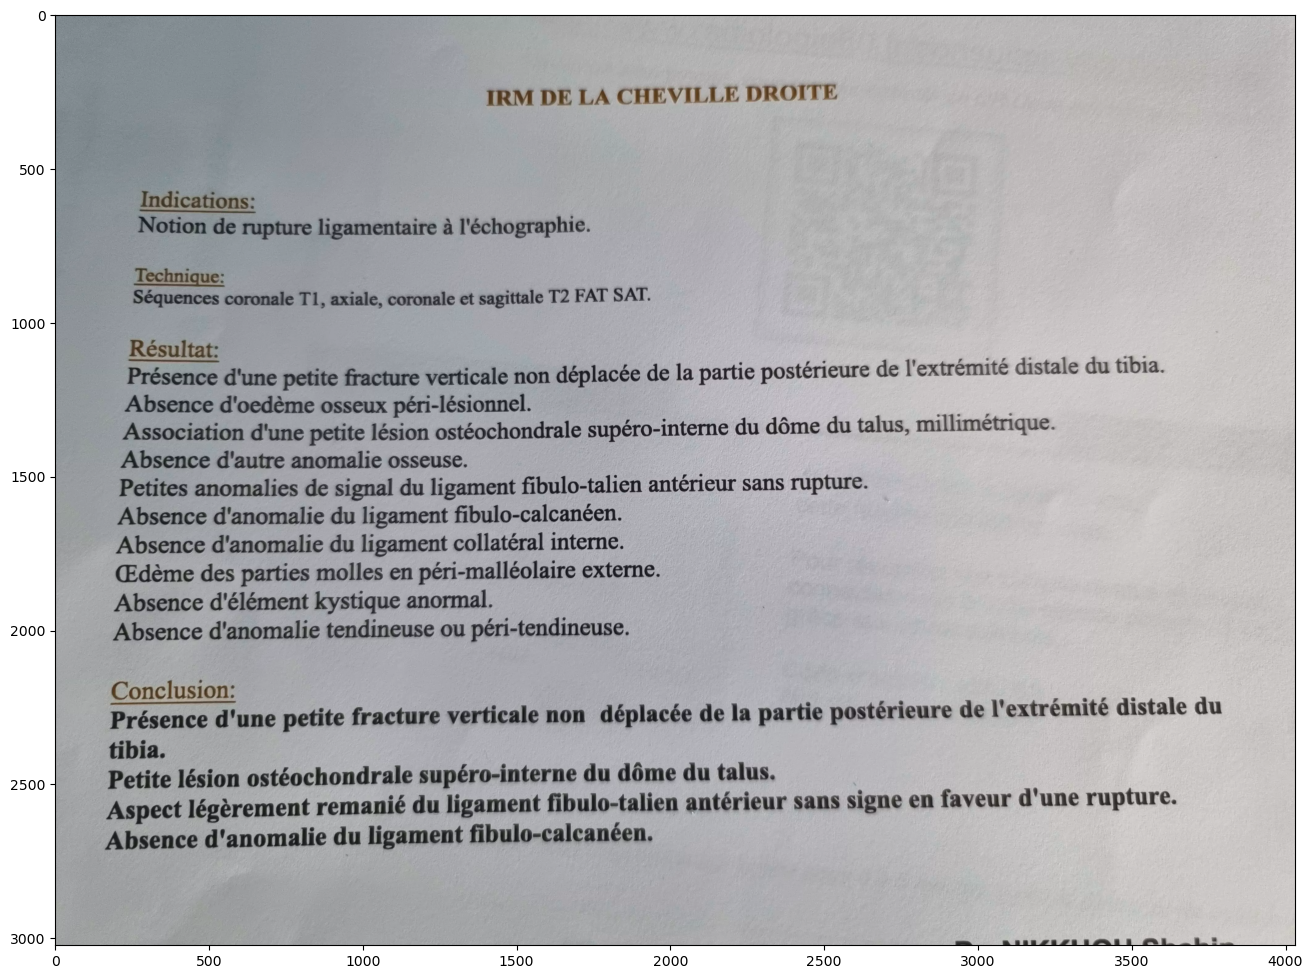

Distance de Levenshtein : 26
Coefficient de Jaccard : 0.8426966292134831
Similarité de Dice : 0.75
cosine similarity :  0.9886293698705345


In [14]:
# preproces_extract_img_2('Imagerie/CR IRM Pelvienne.jpg')
#preproces_extract_img_2('Imagerie/CR hysteroscopie.jpg')
preproces_extract_img_4('Imagerie/CR partiel IRM cheville.jpg')
lev ,jaccard , dice ,cosine=calcul_metric('Resultat/Test_Txt/CR partiel IRM cheville_OCR.txt' ,'Resultat/Txt/CR partiel IRM cheville.txt')


In [17]:
import pandas as pd 
# Création d'une liste de dictionnaires contenant les données pour chaque ligne
data = [
    {'img_name':'Angioscanner thoracique' , 'Distance de Levenshtein': 112, 'Coefficient de Jaccard': 0.60,
     'Similarité de Dice': 0.42 , 'cosine_similarity':0.92},

    {'img_name':'CR arthroscopie' , 'Distance de Levenshtein': 411, 'Coefficient de Jaccard': 0.48,
     'Similarité de Dice': 0.27 , 'cosine_similarity':0.89},
    
    {'img_name':'CR coloscopie' , 'Distance de Levenshtein': 429, 'Coefficient de Jaccard': 0.53,
     'Similarité de Dice': 0.36 , 'cosine_similarity':0.87},

    {'img_name':'CR colposcopie' , 'Distance de Levenshtein': 1049, 'Coefficient de Jaccard': 0.00,
     'Similarité de Dice': 0.00 , 'cosine_similarity':0.00},

    {'img_name':'CR consultation' , 'Distance de Levenshtein': 267, 'Coefficient de Jaccard': 0.46,
     'Similarité de Dice': 0.27 , 'cosine_similarity':0.90},

    {'img_name':'CR coronarographie' , 'Distance de Levenshtein': 103, 'Coefficient de Jaccard': 0.74,
     'Similarité de Dice': 0.54 , 'cosine_similarity':0.96},

    {'img_name':'CR écho abdo' , 'Distance de Levenshtein': 31, 'Coefficient de Jaccard': 0.87,
     'Similarité de Dice': 0.80 , 'cosine_similarity':0.98},

    {'img_name':'CR echo abdominopelvienne' , 'Distance de Levenshtein': 137, 'Coefficient de Jaccard': 0.68,
     'Similarité de Dice': 0.53 , 'cosine_similarity':0.96},

    {'img_name':'CR echo doppler' , 'Distance de Levenshtein': 500, 'Coefficient de Jaccard': 0.64,
     'Similarité de Dice': 0.45 , 'cosine_similarity':0.94},

    {'img_name':'CR echo obstetricale' , 'Distance de Levenshtein': 1394, 'Coefficient de Jaccard': 0.11,
     'Similarité de Dice': 0.01 , 'cosine_similarity':0.43},

    {'img_name':'CR Echo prostate' , 'Distance de Levenshtein': 511, 'Coefficient de Jaccard': 0.37,
     'Similarité de Dice': 0.19 , 'cosine_similarity':0.72},

    {'img_name':'CR echo-pelv' , 'Distance de Levenshtein': 13, 'Coefficient de Jaccard': 0.89,
     'Similarité de Dice': 0.84 , 'cosine_similarity':0.99},

    {'img_name':'CR gastroscopie' , 'Distance de Levenshtein': 233, 'Coefficient de Jaccard': 0.39,
     'Similarité de Dice': 0.25 , 'cosine_similarity':0.74},
    
    {'img_name':'CR CR hysteroscopie' , 'Distance de Levenshtein': 648, 'Coefficient de Jaccard': 0.10,
     'Similarité de Dice': 0.00 , 'cosine_similarity':0.32},
    
    {'img_name':'CR IRM cérébrale 2' , 'Distance de Levenshtein': 1678, 'Coefficient de Jaccard': 0.00,
     'Similarité de Dice': 0.00 , 'cosine_similarity':0.00},
    
    {'img_name':'CR IRM cérébrale 3' , 'Distance de Levenshtein': 394, 'Coefficient de Jaccard': 0.10,
     'Similarité de Dice': 0.67 , 'cosine_similarity':0.94},
    
    {'img_name':'CR IRM cérébrale 4' , 'Distance de Levenshtein': 1333, 'Coefficient de Jaccard': 0.12,
     'Similarité de Dice': 0.00 , 'cosine_similarity':0.50},

    {'img_name':'CR IRM cérébrale' , 'Distance de Levenshtein': 86, 'Coefficient de Jaccard':0.68,
     'Similarité de Dice': 0.53 , 'cosine_similarity':0.95},

    {'img_name':'CR IRM cerebrale2' , 'Distance de Levenshtein': 330, 'Coefficient de Jaccard': 0.55,
     'Similarité de Dice': 0.41 , 'cosine_similarity':0.95},

    {'img_name':'CR IRM genou' , 'Distance de Levenshtein': 20, 'Coefficient de Jaccard': 0.87,
     'Similarité de Dice': 0.80 , 'cosine_similarity':0.99},

    {'img_name':'CR IRM lombaire' , 'Distance de Levenshtein': 226, 'Coefficient de Jaccard': 0.77,
     'Similarité de Dice': 0.65 , 'cosine_similarity':0.97},
    
    {'img_name':'CR IRM mammaire 1A' , 'Distance de Levenshtein': 674, 'Coefficient de Jaccard': 0.50,
     'Similarité de Dice': 0.29 , 'cosine_similarity':0.86},

    {'img_name':'CR IRM partiel' , 'Distance de Levenshtein': 127, 'Coefficient de Jaccard': 0.77,
     'Similarité de Dice': 0.68 , 'cosine_similarity':0.92},
    
    {'img_name':'CR IRM Pelvienne' , 'Distance de Levenshtein': 304, 'Coefficient de Jaccard': 0.75,
     'Similarité de Dice': 0.65 , 'cosine_similarity':0.95},
    
    {'img_name':'CR IRM plexus brachial' , 'Distance de Levenshtein': 186, 'Coefficient de Jaccard': 0.12,
     'Similarité de Dice': 0.02 , 'cosine_similarity':0.21},
    
    {'img_name':'CR IRM Rachis cervical' , 'Distance de Levenshtein': 588, 'Coefficient de Jaccard': 0.10,
     'Similarité de Dice': 0.01 , 'cosine_similarity':0.52},
    
    {'img_name':'CR IRM Rachis cervicale' , 'Distance de Levenshtein': 196, 'Coefficient de Jaccard': 0.80,
     'Similarité de Dice': 0.66 , 'cosine_similarity':0.98},
    
    {'img_name':'CR IRM-prostate-schema' , 'Distance de Levenshtein': 1483, 'Coefficient de Jaccard': 0.36,
     'Similarité de Dice': 0.14 , 'cosine_similarity':0.82},

    {'img_name':'CR mammographie' , 'Distance de Levenshtein': 780, 'Coefficient de Jaccard': 0.26,
     'Similarité de Dice': 0.11 , 'cosine_similarity':0.72},

    {'img_name':'CR mammographie 1A' , 'Distance de Levenshtein':832, 'Coefficient de Jaccard': 0.5,
     'Similarité de Dice': 0.21 , 'cosine_similarity':0.97},

    {'img_name':'CR mammographie 1B' , 'Distance de Levenshtein': 1345, 'Coefficient de Jaccard': 0.24,
     'Similarité de Dice': 0.07 , 'cosine_similarity':0.71},

    {'img_name':'CR mammographie2' , 'Distance de Levenshtein': 179, 'Coefficient de Jaccard': 0.55,
     'Similarité de Dice': 0.33 , 'cosine_similarity':0.89},

    {'img_name':'CR partiel IRM cheville' , 'Distance de Levenshtein': 973, 'Coefficient de Jaccard': 0.03,
     'Similarité de Dice': 0.00 , 'cosine_similarity':0.09},

    {'img_name':'CR radio rachis' , 'Distance de Levenshtein': 581, 'Coefficient de Jaccard': 0.27,
     'Similarité de Dice': 0.10 , 'cosine_similarity':0.78},
    
    {'img_name':'CR scanner abdominal' , 'Distance de Levenshtein': 1005, 'Coefficient de Jaccard': 0.38,
     'Similarité de Dice': 0.20 , 'cosine_similarity':0.84},
    
    {'img_name':'CR scintigraphie 2' , 'Distance de Levenshtein': 281, 'Coefficient de Jaccard': 0.51,
     'Similarité de Dice': 0.32 , 'cosine_similarity':0.89},

]

# Création du DataFrame à partir de la liste de dictionnaires
df = pd.DataFrame(data)
df
# df.to_csv('Resultat/Metric_result.csv',index=False)



,img_name,Distance de Levenshtein,Coefficient de Jaccard,Similarité de Dice,cosine_similarity
0,Angioscanner thoracique,112,0.60,0.42,0.92
1,CR arthroscopie,411,0.48,0.27,0.89
2,CR coloscopie,429,0.53,0.36,0.87
3,CR colposcopie,1049,0.00,0.00,0.00
4,CR consultation,267,0.46,0.27,0.90
5,CR coronarographie,103,0.74,0.54,0.96
6,CR écho abdo,31,0.87,0.80,0.98
7,CR echo abdominopelvienne,137,0.68,0.53,0.96
8,CR echo doppler,500,0.64,0.45,0.94
9,CR echo obstetricale,1394,0.11,0.01,0.43


CONCLU:
on peut conculre que la resolution ca pourait etre un bon facteur a implementer qu'on fait face a une qualite d'image degrade et meme qu'on a des images avec des bons on remarque que la resolution genre plus au moins les meilleures resulats 

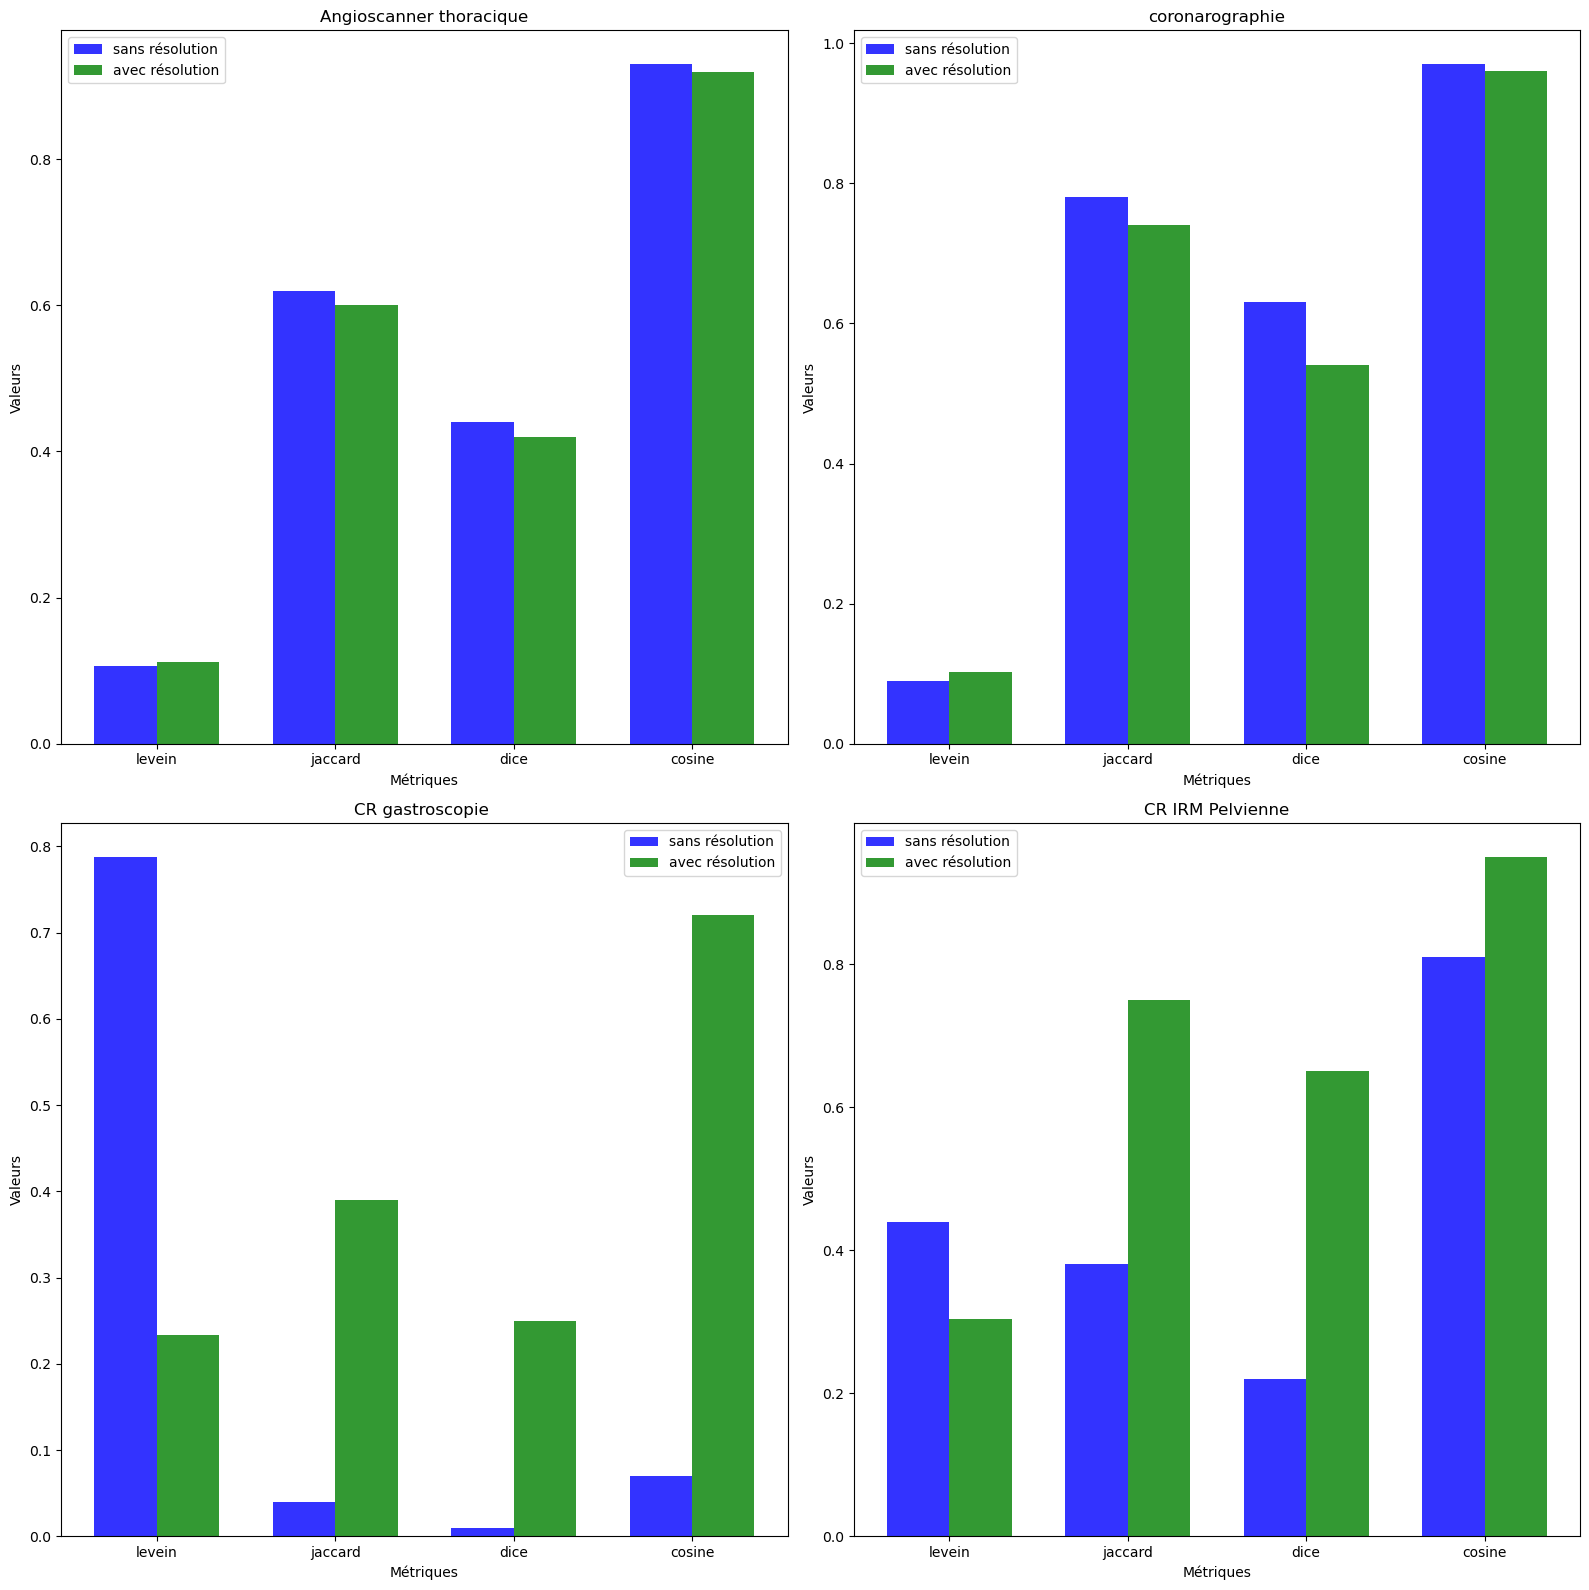

In [104]:
import matplotlib.pyplot as plt
import numpy as np

# données à représenter
metriques = ['levein', 'jaccard', 'dice', 'cosine'] # les noms de vos 4 métriques

# Créer l'histogramme
fig, axes = plt.subplots(2,2, figsize=(16,16))
sans_res_1 = [0.106, 0.62, 0.44, 0.93] # les valeurs pour "sans résolution"
avec_res_1 = [0.112, 0.60, 0.42, 0.92] # les valeurs pour "avec résolution"
index = np.arange(len(metriques))
bar_width = 0.35
opacity = 0.8

#hist_1
rects1 = axes[0,0].bar(index, sans_res_1, bar_width,
alpha=opacity,
color='b',
label='sans résolution')

rects2 = axes[0,0].bar(index + bar_width, avec_res_1, bar_width,
alpha=opacity,
color='g',
label='avec résolution')

#hist_2
sans_res_2 = [0.090, 0.78, 0.63, 0.97] # les valeurs pour "sans résolution"
avec_res_2 = [0.103, 0.74, 0.54, 0.96] # les valeurs pour "avec résolution"
rects1 = axes[0,1].bar(index, sans_res_2, bar_width,
alpha=opacity,
color='b',
label='sans résolution')

rects2 = axes[0,1].bar(index + bar_width, avec_res_2, bar_width,
alpha=opacity,
color='g',
label='avec résolution')

#hist_3
sans_res_3 = [0.788, 0.04, 0.01, 0.07] # les valeurs pour "sans résolution"
avec_res_3 = [0.233, 0.39, 0.25, 0.72] # les valeurs pour "avec résolution"
rects1 = axes[1,0].bar(index, sans_res_3, bar_width,
alpha=opacity,
color='b',
label='sans résolution')

rects2 = axes[1,0].bar(index + bar_width, avec_res_3, bar_width,
alpha=opacity,
color='g',
label='avec résolution')

#hist_4
sans_res_4 = [0.440, 0.38, 0.22, 0.81] # les valeurs pour "sans résolution"
avec_res_4 = [0.304, 0.75, 0.65, 0.95] # les valeurs pour "avec résolution"
rects1 = axes[1,1].bar(index, sans_res_4, bar_width,
alpha=opacity,
color='b',
label='sans résolution')

rects2 = axes[1,1].bar(index + bar_width, avec_res_4, bar_width,
alpha=opacity,
color='g',
label='avec résolution')

# Ajouter les légendes et les labels d'axes
for ax in axes.flatten():
    ax.set_xlabel('Métriques')
    ax.set_ylabel('Valeurs')
    # ax.set_title('Comparaison des valeurs de métriques entre deux catégories')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(metriques)
    ax.legend()

axes[0,0].set_title('Angioscanner thoracique')
axes[0,1].set_title('coronarographie')
axes[1,0].set_title('CR gastroscopie ')
axes[1,1].set_title('CR IRM Pelvienne')

# Afficher le graphique
plt.tight_layout()
plt.show()


Pour l'algorithme de detection on remarque que ca permet d'ameliorer les resultas par rapport a une detection normale du documents en ce qui concerne la reconnaissance la qualite d'image  reste un facteur tres important 

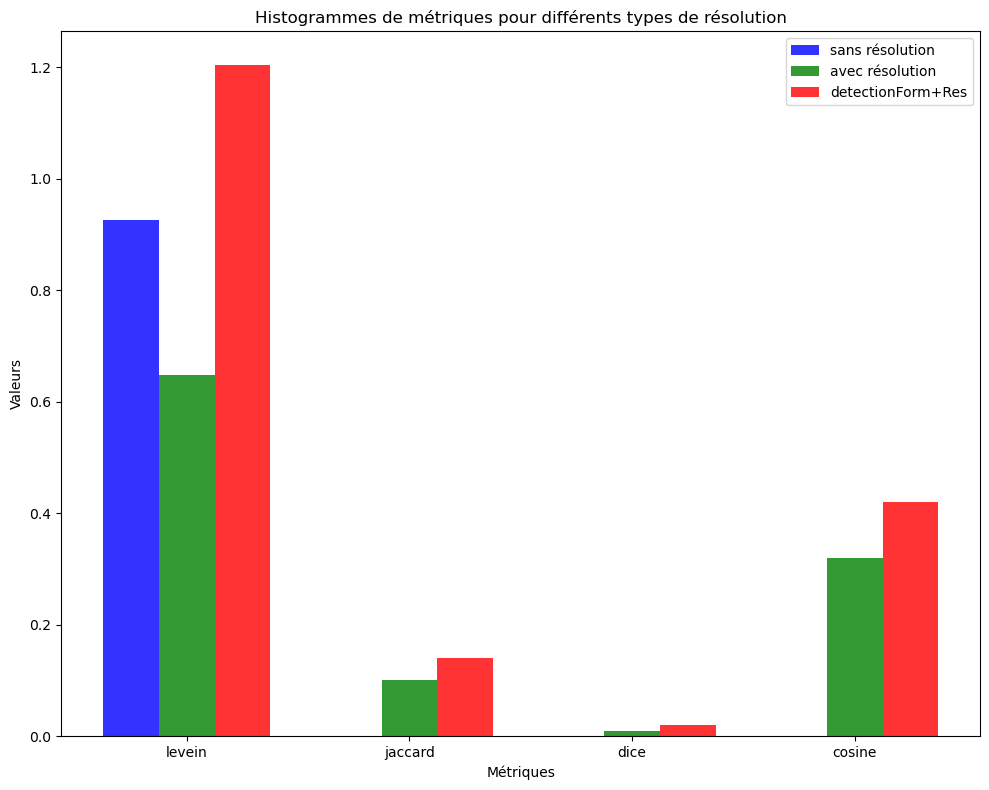

In [2]:
import matplotlib.pyplot as plt
import numpy as np


metriques = ['levein', 'jaccard', 'dice', 'cosine'] # Les noms de vos 4 métriques

# Créer l'histogramme
fig, axe = plt.subplots(figsize=(10, 8))
avec_res_5 = [0.648, 0.10, 0.01, 0.32] # Les valeurs pour "avec résolution"
sans_res_5 = [0.926, 0.00, 0.00, 0.00] # Les valeurs pour "sans résolution"
res_det_5 = [1.204, 0.14, 0.02, 0.42] # Les valeurs pour "detectionForm+Res"
index = np.arange(len(metriques))
bar_width = 0.25
opacity = 0.8

# Créer les barres pour chaque ensemble de données
rects1 = axe.bar(index, sans_res_5, bar_width,
alpha=opacity,
color='b',
label='sans résolution')

rects2 = axe.bar(index + bar_width, avec_res_5, bar_width,
alpha=opacity,
color='g',
label='avec résolution')

rects3 = axe.bar(index + 2*bar_width, res_det_5, bar_width,
alpha=opacity,
color='r',
label='detectionForm+Res')

# Ajouter les légendes et les labels d'axes
axe.set_xlabel('Métriques')
axe.set_ylabel('Valeurs')
axe.set_title('CR hystrescopie')
axe.set_xticks(index + bar_width)
axe.set_xticklabels(metriques)
axe.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()

le Pretraitement geometrique peut avoir un impact considerable sur les resultats de l'ocr alors il est preferable de faire pivoter l'image autour de son centre de rotation pour la mettre dans une orientation correcte avant de proceder a la detection et reconnaissance du text .

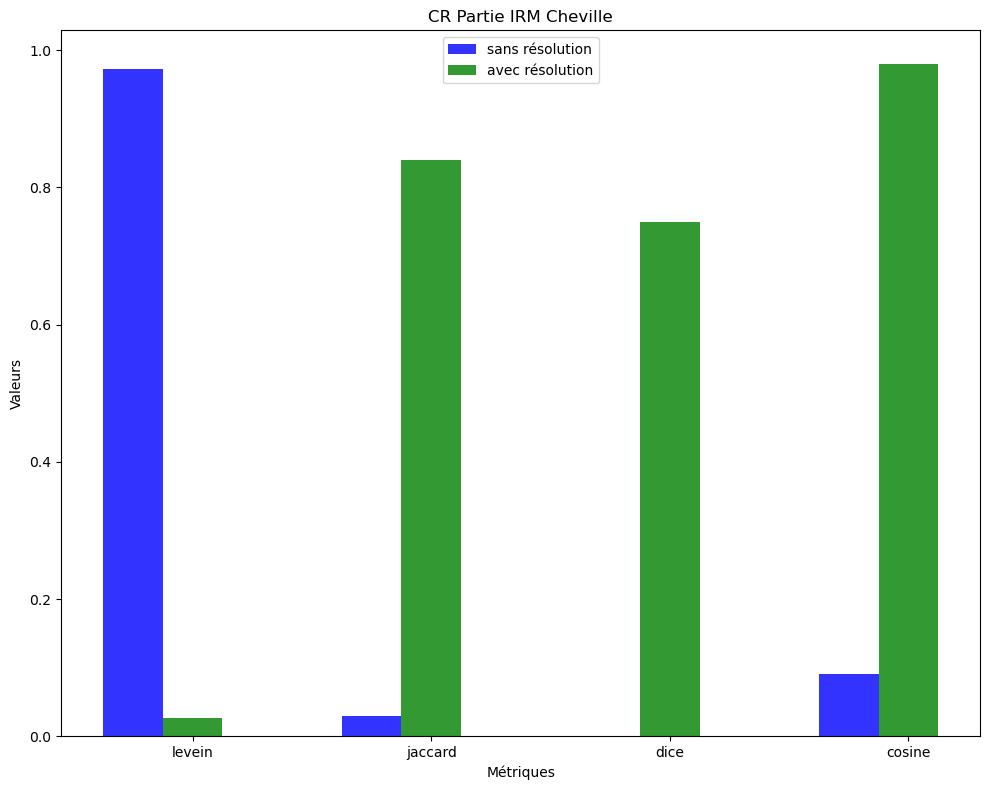

In [16]:
import matplotlib.pyplot as plt
import numpy as np


metriques = ['levein', 'jaccard', 'dice', 'cosine'] # Les noms de vos 4 métriques

# Créer l'histogramme
fig, axe = plt.subplots(figsize=(10, 8))
sans_rot = [0.973, 0.03, 0.00, 0.09] # Les valeurs pour "avec résolution"
avec_rot = [0.026, 0.84,0.75, 0.98] # Les valeurs pour "sans résolution"
index = np.arange(len(metriques))
bar_width = 0.25
opacity = 0.8

# Créer les barres pour chaque ensemble de données
rects1 = axe.bar(index, sans_rot, bar_width,
alpha=opacity,
color='b',
label='sans résolution')

rects2 = axe.bar(index + bar_width, avec_rot, bar_width,
alpha=opacity,
color='g',
label='avec résolution')

# Ajouter les légendes et les labels d'axes
axe.set_xlabel('Métriques')
axe.set_ylabel('Valeurs')
axe.set_title('CR Partie IRM Cheville')
axe.set_xticks(index + bar_width)
axe.set_xticklabels(metriques)
axe.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()